<a href="https://colab.research.google.com/github/xtyangpsp/HarvardEPS_MLclass2019/blob/master/week3_quakedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import layers, models, regularizers
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import to_categorical
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

Using TensorFlow backend.


Here we link the class google drive to this notebook

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the training data

In [0]:
!ls "/content/drive/My Drive/EPS268-ML/TUTORIALS/Quake_detection_week3"

# load OK029 template data:
with h5py.File("/content/drive/My Drive/EPS268-ML/TUTORIALS/Quake_detection_week3/templates_029.h5", "r") as f:
    crap1 = np.asarray(f['earthquakes'])
    crap2=np.asarray(f["noise"])

    # load OK027 template data:
with h5py.File("/content/drive/My Drive/EPS268-ML/TUTORIALS/Quake_detection_week3/templates_027.h5", "r") as f:
    crap1 = np.asarray(f['earthquakes'])
    crap2=np.asarray(f["noise"])

convnetquake_in_keras.py  templates_027.h5
OK027_july_2014.h5	  templates_029.h5


Make the training data

In [0]:
# make training data
quakes=np.zeros(shape=(len(crap1[:,1,1]),1000,3),dtype=np.float32)
noise=np.zeros(shape=(len(crap1[:,1,1]),1000,3),dtype=np.float32)
quakes2=np.zeros(shape=(len(crap2[:,1,1]),1000,3),dtype=np.float32)
noise2=np.zeros(shape=(len(crap2[:,1,1]),1000,3),dtype=np.float32)
for iq in range(len(quakes[:,1,1])):
    for ic in range(3):
        if np.max(np.abs(crap1[iq,ic,:]))>0:
            quakes[iq,:,ic]=crap1[iq,ic,:]/np.max(np.abs(crap1[iq,ic,:]))
        if np.max(np.abs(crap2[iq,ic,:]))>0:
            noise[iq,:,ic]=crap2[iq,ic,:]/np.max(np.abs(crap2[iq,ic,:]))

for iq in range(len(crap1[:,1,1])):
    for ic in range(3):
        if np.max(np.abs(crap1[iq,ic,:]))>0:
            quakes2[iq,:,ic]=crap1[iq,ic,:]/np.max(np.abs(crap1[iq,ic,:]))
        if np.max(np.abs(crap2[iq,ic,:]))>0:
            noise2[iq,:,ic]=crap2[iq,ic,:]/np.max(np.abs(crap2[iq,ic,:]))
iq1=np.where( ( np.abs(quakes[:,0,0])>0)&(np.isfinite(quakes[:,0,0])))[0]
iq2=np.where( (np.abs(quakes2[:,0,0])>0)&(np.isfinite(quakes2[:,0,0])))[0]
print('done preparing the training data')

done preparing the training data


In [0]:
# label data
train_labels = np.concatenate((np.ones(len(iq1)+len(iq2),dtype=np.int),np.zeros(len(iq1)+len(iq2),dtype=np.int)))#+noise3.shape[0])))
train_waves = np.zeros(shape=(len(train_labels),1000,3,1))
train_waves[:,:,:,0] = np.concatenate((quakes[iq1,:,:],quakes2[iq2,:,:],noise[iq1,:,:],noise2[iq2,:,:]),axis=0)
y_binary = to_categorical(train_labels)
indx=np.random.choice(len(train_labels),len(train_labels))

# train data is 80% of the entire data set
ntrain = np.arange(0,round(0.8*len(indx)))
ntest = np.arange(ntrain[-1]+1,len(indx))
print("number of training samples",len(ntrain),"number of test tests",len(ntest))

number of training samples 12710 number of test tests 3178


In [0]:
l2, cats = 0.00001,2 # learning rate, number of classes output

# building the architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1000,3,1), use_bias=True, strides=(2,2), kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=(2,2), kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
# model.add(layers.Conv2D(32, (3, 3), activation='relu', use_bias=True, strides=2, kernel_regularizer=regularizers.l2(l2), padding='SAME'))
model.add(layers.Flatten())
model.add(layers.Dense(cats, activation='softmax'))
# compile the network
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# training
history=model.fit(train_waves[indx[ntrain],:,:,:], y_binary[indx[ntrain]],validation_split=0.2, epochs=20, batch_size=128,shuffle=True)
# save the weights
weights1=model.get_weights()

print(len(weights1))

# testing
test=model.evaluate(train_waves[indx[ntest],:,:,:], y_binary[indx[ntest]],batch_size=64,verbose=1)
print('loss and accuracy at test')
print(test)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 10168 samples, validate on 2542 samples
Epoch 1/20
10168/10168 [==============================] - 7s 717us/step - loss: 0.1610 - acc: 0.9400 - val_loss: 0.0227 - val_acc: 0.9976
Epoch 2/20
10168/10168 [==============================] - 1s 70us/step - loss: 0.0116 - acc: 0.9976 - val_loss: 0.0099 - val_acc: 0.9961
Epoch 3/20
10168/10168 [==============================] - 1s 67us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 4/20
10168/10168 [==============================] - 1s 67us/step - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0044 - val_acc: 0.9972
Epoch 5/20
10168/10168 [==============================] - 1s 69us/step - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0017 - val_acc: 0.9988
Epoch 6/20
10168/10168 [==============================] - 1s 69us/step - loss: 7.7393e-04 - acc: 1.0000 - val_loss: 7.3153e-04 - val_acc: 1.0000
Epoch 7/20
10168/101

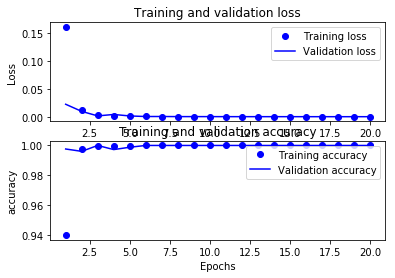

In [0]:

# check for overfitting
history_dic = history.history
loss_values = history_dic['loss']
val_loss_values = history_dic['val_loss']
acc_values = history_dic['acc']
val_acc_values = history_dic['val_acc']
epochs=range(1,len(loss_values)+1)
fig,ax=plt.subplots(2)
ax[0].plot(epochs,loss_values,'bo',label='Training loss')
ax[0].plot(epochs,val_loss_values,'b',label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs,acc_values,'bo',label='Training accuracy')
ax[1].plot(epochs,val_acc_values,'b',label='Validation accuracy')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()


# predict on continuous data

In [0]:
# load long data:
with h5py.File("/content/drive/My Drive/EPS268-ML/TUTORIALS/Quake_detection_week3/OK027_july_2014.h5", "r") as f:
    crap1 = np.asarray(f['seismic-data'])
print(crap1.shape)


[[  895.   870.   831. ...  1401.  1395.  1407.]
 [ 1958.  1971.  1947. ...  1721.  1716.  1725.]
 [ 1365.  1383.  1390. ... -4793. -4797. -4783.]]


(3, 267839901)


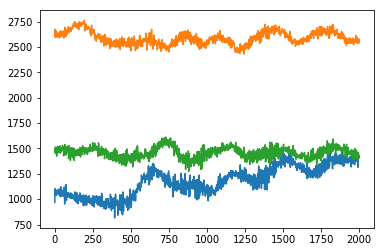

In [0]:
plt.plot(crap1[:,10000:12000].transpose())
print(crap1.shape)

In [0]:
# here you want to slide through the data.
twin= 10 # seconds
sps = 100 # 100Hz sampling rate
stepsize = 2 # every 2 seconds
nwin = int(twin*sps)
nsps = int(stepsize*sps)
i=0
while i < crap1.shape[1]:
  print(i/100,(i+nwin)/100)
#   window0 = crap1[0, i:i+nwin]
  model.predict(crap1[:,i:i+nwin])
  
  
  exit()
  
  i+=nsps

0.0 10.0


ValueError: ignored